**Object detection with linear models**

---

**Overview** - In this project we will try to teach the computer to recognize a hand in a picture , the hand in our dataset corresponds to a sign language gesture (which represents a letter in the alphabet)

**Goal** - We want to focus only on the hand gesture that is part of the picture , and teach the computer that when it gets a new picture of a person doing a hand gesture of a sign in sign language , it would know to identify and focus on the hand inside the picture.

**Learning process** - We would first get dataset of pictures and some CSV files that include information about the bounding boxes for the pictures.
The bounding box is a rectangle defined by its topleft and bottom-right corners,
Hence 𝐲=(𝑦1, 𝑦2, 𝑦3, 𝑦4). The detected object -- a hand gesturing a sign -- is to be inside this bounding box. The computer would train on part of the dataset (called training set) , using the correct bounding box for each picture and would eventually learn to recognize the bounding box itself.
The learning would be implemented using a Linear model called 'Linear regression'

**Validation process** - The computer will get a set of pictures (which was not part of the training set) with their true bounding box indexes and check how close his prediction is to the actual indexes.

**import statements**

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import csv
from os import listdir
from os.path import join
from random import randint
from PIL import Image
import zipfile
import os
from skimage.transform import resize
import urllib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches

**constans declaration**

In [0]:
included_extensions = 'jpg'
data_url = 'https://github.com/yoavram/Sign-Language/raw/master/Dataset.zip'
directory = './Dataset'
data_filename = './Dataset.zip'
CSV_postfix = 'csv'

**function definitions**

In [0]:
# load zip file

def loadZip(data_url=data_url,data_filename=data_filename):
    if not os.path.exists(data_filename):
        urllib.request.urlretrieve(data_url, data_filename)
    print("Data file exists:", os.path.exists(data_filename))

In [0]:
#extract zip data to directory

def extractZip(data_filename=data_filename):
    zip_ref = zipfile.ZipFile(data_filename, 'r')
    zip_ref.extractall()
    zip_ref.close()


In [0]:
# add cropped JPGs and labels to list

def createLists(directory=directory):
    dataArray = []
    box_cords = []
    dictionary = dict()
    for user in os.listdir(directory):
        for file in os.listdir(os.path.join(directory,user)):
            if file.endswith(CSV_postfix):
                data = pd.read_csv(os.path.join(directory,user,file))
                for _, row in data.iterrows():
                    boundarybox = row['top_left_x'], row['bottom_right_x'], row['top_left_y'], row['bottom_right_y']
                    image = np.array(Image.open(os.path.join(directory,row['image'])))
                    dataArray.append(image)
                    box_cords.append(boundarybox)
    return np.array(dataArray),np.array(box_cords)


In [0]:
# initialization function

def init():
    loadZip()
    extractZip()
    return createLists()

In [0]:
def iou(y_hat, y):
    # coordinates of intersection rectangle
    x_left = np.maximum(y_hat[:,0], y[:,0])
    y_top = np.maximum(y_hat[:,2],y[:,2])
    x_right = np.minimum(y_hat[:,1],y[:,1])
    y_bottom = np.minimum(y_hat[:,3],y[:,3])

    # The intersection area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # area of both rectangles
    y_hat_area = (y_hat[:,1] - y_hat[:,0]) * (y_hat[:,3] - y_hat[:,2])
    y_area = (y[:,1] - y[:,0]) * (y[:,3] - y[:,2])

    # compute iou
    iou = intersection_area / (y_hat_area + y_area - intersection_area)
    return iou

**Starting the code run**

In [26]:
# initialize the data

dataArray, boundaries = init()

Data file exists: True


In [0]:
# split the data to training and testing 

X_train, X_test , Y_train , Y_test = train_test_split(dataArray, boundaries,test_size=0.25)

In [0]:
model = LinearRegression(fit_intercept=False)

In [0]:
# reshape training data to fit the linear model

nsamples_train , height_train , width_train, channels_train = X_train.shape 
reshaped_X_train = X_train.reshape(nsamples_train,height_train*width_train*channels_train)

In [30]:
# train the model 

model.fit(reshaped_X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [0]:
# reshape testing data to fit the linear model

nsamples_test , height_test , width_test, channels_test = X_test.shape 
reshaped_X_test = X_test.reshape(nsamples_test,height_test*width_test*channels_test)

In [0]:
# predict test data

predicted_of_test = model.predict(reshaped_X_test)

In [0]:
# choose 9 random pictures

samples_idx = np.random.choice(len(dataArray),9)
X_samples = dataArray[samples_idx]
Y_labels = boundaries[samples_idx]
nsamples , height , width, channels = X_samples.shape 
reshaped_X_samples = X_samples.reshape(nsamples,height*width*channels)
X_prediction = model.predict(reshaped_X_samples)

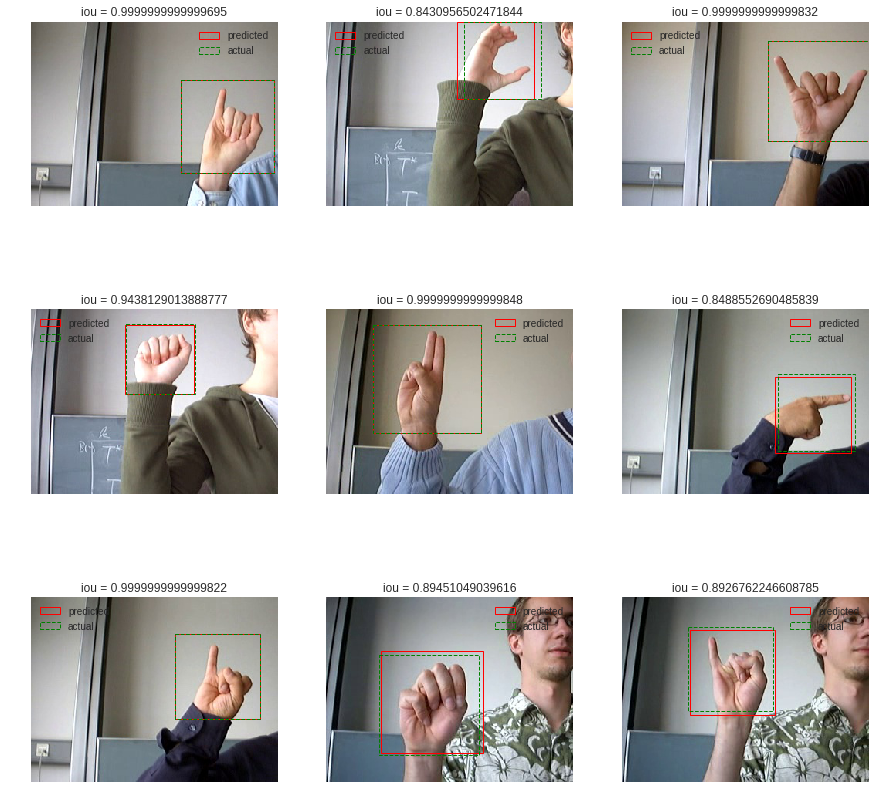

In [34]:
# plot the 9 random pictures with the actual boundary box and the predicted one

iou_random_images_results = iou(X_prediction,Y_labels)

fig,ax = plt.subplots(3,3,figsize=(15, 15))

for i in range(len(Y_labels)):
    ax = plt.subplot(3,3,i+1)
    rect_pred = patches.Rectangle((X_prediction[i][0],X_prediction[i][2]),X_prediction[i][1]-X_prediction[i][0],X_prediction[i][3]-X_prediction[i][2],linewidth=1,edgecolor='r',facecolor='none', label = 'predicted')
    rect_actual = patches.Rectangle((Y_labels[i][0],Y_labels[i][2]),Y_labels[i][1]-Y_labels[i][0],Y_labels[i][3]-Y_labels[i][2],linewidth=1,edgecolor='g',facecolor='none',linestyle='dashed',label='actual')
    plt.title('iou = {}'.format(iou_random_images_results[i]))
    ax.add_patch(rect_pred)
    ax.add_patch(rect_actual)
    ax.imshow(X_samples[i])
    ax.set_axis_off()  
    plt.legend()

plt.show()


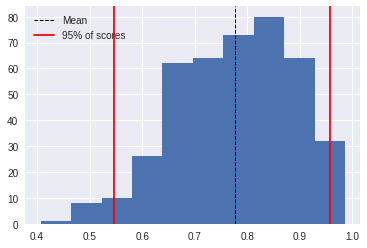

In [35]:
# plot IOU results with mean and 95% of data confidence

iou_results = iou(predicted_of_test,Y_test)

plt.hist(iou_results)

precentile_2_point_5 = np.percentile(iou_results, 2.5) 
precentile_97_point_5 = np.percentile(iou_results, 97.5) 

plt.axvline(iou_results.mean(), color='k', linestyle='dashed', linewidth=1 , label = 'Mean')
plt.axvline(x=precentile_2_point_5, color='r', linestyle='-', label = '95% of scores')
plt.axvline(x=precentile_97_point_5, color='r', linestyle='-')

plt.legend()



In [36]:
# print final results 

print('Mean of IOU is: {:.2f}'.format(iou_results.mean()))
print('95% of the IOU scores are between: {:.2f} to {:.2f}'.format(precentile_2_point_5,precentile_97_point_5))

Mean of IOU is: 0.78
95% of the IOU scores are between: 0.55 to 0.96


**End**